<a href="https://colab.research.google.com/github/loaywael/CIFAR10_Resnet_v2/blob/master/Cifar10_ResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.1.0
# !pip install tf-nightly

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!mkdir "/gdrive/My Drive/CifarNet"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
mkdir: cannot create directory ‘/gdrive/My Drive/CifarNet’: File exists


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, callbacks
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from time import time
import pickle
import os 


def convLayer(X, f, k, s=1, p="valid", weightsDecay=None, bias=True, name=""):
    regularizer = None
    if weightsDecay:
        regularizer = l2(weightsDecay)
    conv_layer = layers.Conv2D(
        filters=f, 
        kernel_size=k,
        strides=s,
        padding=p,
        # kernel_initializer="he_uniform",
        kernel_regularizer=regularizer,
        use_bias=bias,
        name=name
    )
    return conv_layer(X)


def ConvBlock(inputs, filters, k_size, strides, stage, block):
    f1, f2, f3 = filters
    blockName = "STAGE_" + str(stage) + "_BLOCK_" + str(block)
    X = convLayer(inputs, f1, k=1, s=strides, weightsDecay=1e-4, name=blockName+"_conv_a")
    X = layers.BatchNormalization(name=blockName+"_bn_a")(X)
    X = layers.Activation("elu", name=blockName+"_activ_a")(X)

    X = convLayer(X, f2, k=k_size, s=1, p="same", weightsDecay=1e-4, name=blockName+"_conv_b")
    X = layers.BatchNormalization(name=blockName+"_bn_b")(X)
    X = layers.Activation("elu", name=blockName+"_activ_b")(X)

    X = convLayer(X, f3, k=1, s=1, weightsDecay=1e-4, name=blockName+"_conv_c")
    X = layers.BatchNormalization(name=blockName+"_bn_c")(X)

    inputs = convLayer(inputs, f3, k=1, s=strides, weightsDecay=1e-4, name=blockName+"_shortcut_conv", bias=False)
    inputs = layers.BatchNormalization(name=blockName+"shortcut_bn")(inputs)
    X = layers.Add(name=blockName+"_merged_shortcut")([inputs, X])
    X = layers.Activation("elu", name=blockName+"_activ_c")(X)
    return X


def IdentityBlock(inputs, filters, k_size, strides, stage, block):
    f1, f2, f3 = filters
    blockName = "STAGE_" + str(stage) + "_BLOCK_" + str(block)
    X = layers.BatchNormalization(name=blockName + "_bn_a1")(inputs)
    X = convLayer(X, f1, k=1, s=1, weightsDecay=1e-4, name=blockName + "_conv_a")
    X = layers.BatchNormalization(name=blockName + "_bn_a2")(inputs)
    X = layers.Activation("elu", name=blockName + "_activ_a")(X)

    X = layers.BatchNormalization(name=blockName + "_bn_b1")(X)
    X = convLayer(X, f2, k=k_size, s=strides, p="same", weightsDecay=1e-4, name=blockName + "_conv_b")
    X = layers.BatchNormalization(name=blockName + "_bn_b2")(X)
    X = layers.Activation("elu", name=blockName + "_activ_b")(X)

    X = layers.BatchNormalization(name=blockName + "_bn_c1")(X)
    X = convLayer(X, f3, k=1, s=1, weightsDecay=1e-4, name=blockName + "_conv_c")
    X = layers.BatchNormalization(name=blockName + "_bn_c2")(X)

    X = layers.Add(name=blockName+"_merged_shortcut")([inputs, X])
    X = layers.Activation("elu", name=blockName+"_activ_c")(X)
    return X


def ResNet(input_shape, n_classes):
    Xin = layers.Input(shape=input_shape)
    # ============= Stage 1 =============
    X = layers.Conv2D(32, 3, padding="same", activation="elu")(Xin)
    X = layers.BatchNormalization()(X)
    X = layers.Dropout(0.2)(X)
    # ============= Stage 2 =============
    X = ConvBlock(X, [64, 64, 256], 3, 1, "2", "1")
    X = IdentityBlock(X, [64, 64, 256], 3, 1, "2", "2")
    X = layers.Dropout(0.2)(X)
    # ============= Stage 3 =============
    X = ConvBlock(X, [128, 128, 512], 3, 2, "3", "3")
    X = IdentityBlock(X, [128, 128, 512], 3, 1, "3", "4")
    X = layers.Dropout(0.2)(X)
    # ============= Stage 4 =============
    X = layers.GlobalAvgPool2D()(X)
    X = layers.Dropout(0.4)(X)

    Y = layers.Dense(n_classes, activation="softmax")(X)
    return Model(inputs=[Xin], outputs=[Y])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

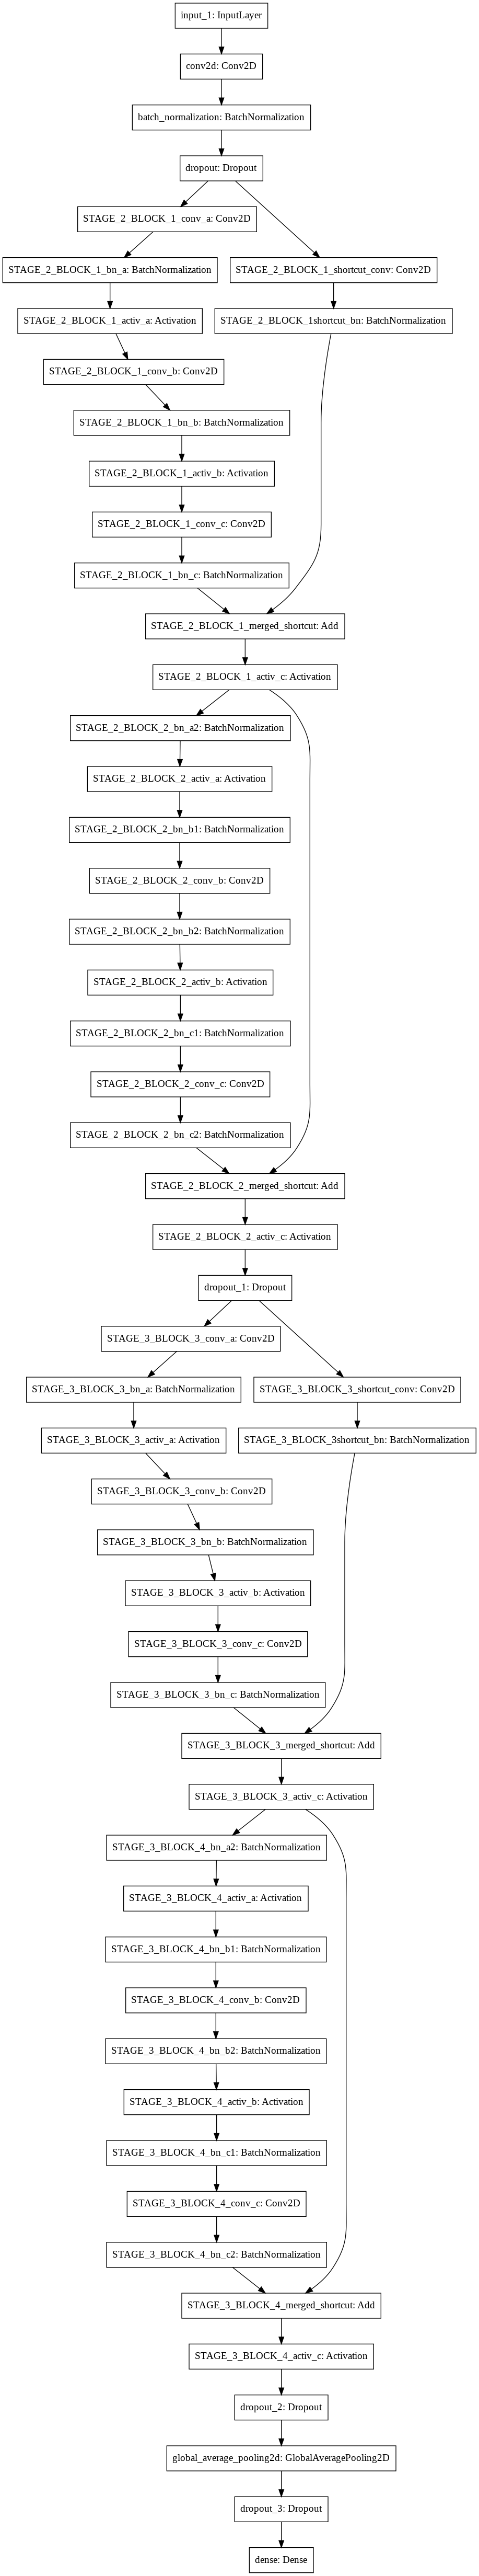

In [ ]:
fX = np.random.randint(1, 10, (16, 32, 32, 3))
fX = tf.constant(fX, dtype=tf.float32)
fY = to_categorical(np.random.randint(0, 10, (16)), 10)
fY = tf.constant(fY, dtype=tf.int32)
fbatch = np.array([fX, fY])
net = ResNet((32, 32, 3), 10)
print(net.summary())
plot_model(net)


In [ ]:
def plotImageBatch(batch, lookupTable):
    batchSize = len(batch[0])
    fig = plt.figure(figsize=(7, 11), dpi=75)
    for i, (x, y) in enumerate(zip(*batch)):
        axis = fig.add_subplot((batchSize//4)+1, 4, i+1)
        axis.imshow(x)
        if len(y) > 2:
            y = y.argmax(axis=-1)
        if len(batch) == 2:
            axis.set_title(lookupTable[str(y)])
        axis.set_xticks([])
        axis.set_yticks([])
    plt.show()


def trainValTestSplit(data, ratio, shuffle=True, seed=41):
        dataIds = list(range(len(data)))
        validationSize = int(len(dataIds) * ratio[1])
        # testSize = int(len(dataIds) * ratio[2])
        if shuffle:
            np.random.seed(seed)
            np.random.shuffle(dataIds)
        validationIds = dataIds[:validationSize]
        # testIds = dataIds[validationSize : validationSize+testSize]
        trainIds = dataIds[validationSize:]
        return data[trainIds], data[validationIds]#, data[testIds]


def plotTrainHistory(train, validation, data_type=""):
    plt.plot(train, c="r")
    plt.plot(validation, c="b")
    plt.title("Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend([f"training_{type}", "validation_{type}"], loc="upper left")
    plt.show()


170500096/170498071 [==============================] - 12s 0us/step
Xtrain, Xvalidation, Xtest:  (45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)
Ytrain, Yvalidation, Ytest:  (45000, 10) (5000, 10) (10000, 10)


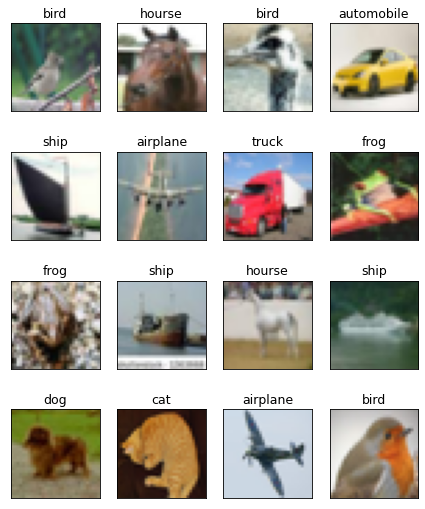

In [ ]:
idLookup = {
        "0": "airplane", "1": "automobile", "2": "bird", "3": "cat", "4": "deer",
        "5": "dog", "6": "frog", "7": "hourse", "8": "ship", "9": "truck"
    }
(Xtrain, Ytrain), (Xtest, Ytest) = datasets.cifar10.load_data()
# X, Y = data[0]
YtrainHot = to_categorical(Ytrain, 10)
YtestHot = to_categorical(Ytest, 10)

Xtrain, Xval = trainValTestSplit(Xtrain, [0.9, 0.1])
YtrainHot, YvalHot = trainValTestSplit(YtrainHot, [0.9, 0.1])
print("Xtrain, Xvalidation, Xtest: ", Xtrain.shape, Xval.shape,  Xtest.shape)
print("Ytrain, Yvalidation, Ytest: ", YtrainHot.shape, YvalHot.shape, YtestHot.shape)

LEN_TRAIN_DATA = len(Xtrain)
LEN_VAL_DATA = len(Xval)
LEN_TEST_DATA = len(Xtest)
batch = (Xtrain[16:32], YtrainHot[16:32])
plotImageBatch(batch, idLookup)


In [ ]:
def lrSchedule(epoch):
    lr = 0.1
    if epoch > 425:
        lr = 0.0001
    elif epoch > 250:
        lr = 0.001
    elif epoch > 100:
        lr = 0.01
    return lr


trainProcessor = image.ImageDataGenerator(
    height_shift_range=0.2,
    # zca_epsilon=1e-6,
    width_shift_range=0.2,
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.3,
    rotation_range=30,
    # brightness_range=[0.5, 1.],
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True
)

testProcessor = image.ImageDataGenerator(
    rescale=1.0/255.0, 
    # zca_epsilon=1e-6,
    featurewise_center=True,
    featurewise_std_normalization=True
)

BATCH_SIZE = 64
trainGen = trainProcessor.flow(Xtrain, YtrainHot, BATCH_SIZE, shuffle=True)
valGen = testProcessor.flow(Xval, YvalHot, BATCH_SIZE, shuffle=True)
testGen = testProcessor.flow(Xtest, YtestHot, BATCH_SIZE, shuffle=True)

In [ ]:
N_EPOCHS = 500
MODEL_PATH = "/gdrive/My Drive/CifarNet/"
HISTORY_PATH = MODEL_PATH + "cifar10_training_history"
BEST_WEIGHTS = MODEL_PATH + "resnet_cifar10_best_weights.h5"

chkpt = callbacks.ModelCheckpoint(
    BEST_WEIGHTS, 
    save_best_only=True, 
    verbose=1, 
    monitor="val_accuracy", 
    mode="max",
)

lrReduce = callbacks.ReduceLROnPlateau(
    factor=0.9, patience = 3, 
    min_lr=1e-4, monitor="val_accuracy",
    mode="max", verbose=0
)

# lrReduce = callbacks.LearningRateScheduler(lrSchedule, verbose=0)
earStop = callbacks.EarlyStopping(patience=50)
callBacks = [chkpt, lrReduce, earStop, callbacks.TensorBoard(log_dir=MODEL_PATH+"cifar10-resnet_v2")]

net = ResNet((32, 32, 3), 10)
if os.path.exists(BEST_WEIGHTS):
    # net.load_weights(BEST_WEIGHTS)
    print("model: ResNet, best weights loaded successfully.")

opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.01)
net.compile(opt, loss="categorical_crossentropy", metrics=["accuracy"])

t1 = time()
history = net.fit_generator(
    trainGen, steps_per_epoch=LEN_TRAIN_DATA//BATCH_SIZE,
    validation_data=valGen, validation_steps=LEN_VAL_DATA//BATCH_SIZE,
    epochs=N_EPOCHS, callbacks=callBacks, initial_epoch=0
)

t2 = time()
history = history.history

with open(HISTORY_PATH, "wb") as wf:
    pickle.dump(history, wf)
print(f"training time: {(t2 - t1)/(60*60):.1f}hr")
net.save_weights(MODEL_PATH + "resnet_cifar10_last_weights.h5")

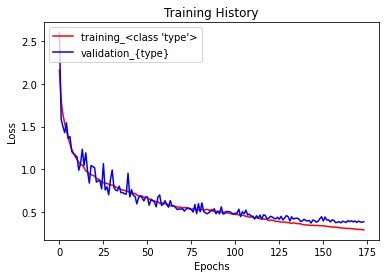

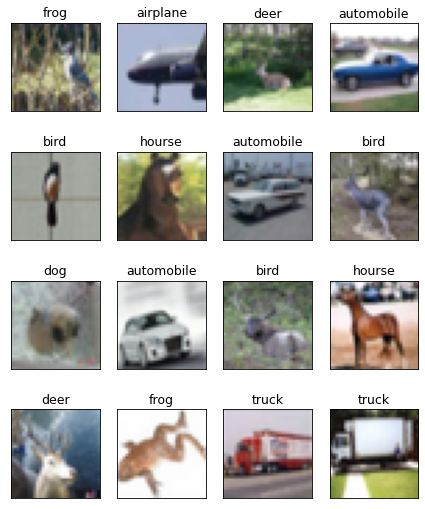

In [ ]:
MODEL_PATH = "/gdrive/My Drive/CifarNet/"
HISTORY_PATH = MODEL_PATH + "cifar10_training_history"
BEST_WEIGHTS = MODEL_PATH + "resnet_cifar10_best_weights.h5"

with open(HISTORY_PATH, "rb") as rf:
    history = pickle.load(rf)

trainLoss = history["loss"]
valLoss = history["val_loss"]
plotTrainHistory(trainLoss, valLoss, data_type="loss")
testImgsBatch = testGen.next()[0][:16]
net.load_weights(MODEL_PATH+"resnet_cifar10_best_weights.h5")
predBatch = net.predict(testImgsBatch)
plotImageBatch((testImgsBatch, predBatch), idLookup)

In [ ]:
from keras import metrics

net = ResNet((32, 32, 3), 10)
if os.path.exists(BEST_WEIGHTS):
    net.load_weights(BEST_WEIGHTS)
    net.load_weights(MODEL_PATH+"resnet_cifar10_last_weights.h5")
    print("model: ResNet, best weights loaded successfully.")

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.01)
metrics = ["accuracy", metrics.Recall(), metrics.Precision()]
net.compile(opt, loss="categorical_crossentropy", metrics=metrics)

testHistory = net.evaluate_generator(testGen, LEN_TEST_DATA//BATCH_SIZE, verbose=1)
print(testHistory)

model: ResNet, best weights loaded successfully.
78/78 [==============================] - 1s 11ms/step - loss: 0.4240 - accuracy: 0.9207 - recall_1: 0.9225 - precision_1: 0.9297
[0.42397093772888184, 0.9206847548484802, 0.9224914312362671, 0.9296579360961914]
